In [25]:
import pandas as pd
import numpy as np
from environment import Environment
from pandas.tseries.offsets import MonthEnd
import instrument
from portfolio import Portfolio
from risk_parity import RiskParity
from copy import copy, deepcopy

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
from historical import HistoricalData
from pandas._libs.tslibs.timestamps import Timestamp, Timedelta

path = "data\\"
env_df = pd.read_csv(path + "Consolidated.csv", header = [0,1], index_col=[0])
targets_df = pd.read_csv(path + "Targets.csv", index_col=[0])
features_df = pd.read_csv(path + "Features.csv", header = [0,1], index_col=[0])
exps = pd.read_csv('data\\ETF_info.csv', index_col=0).loc[env_df[['EQ', 'EM', 'RE', 'FI']].columns.droplevel(), 'Expense Ratio'].astype(float)
data = HistoricalData(env_df, features_df, targets_df)

date = Timestamp('2014-03-01') + MonthEnd(0)
date_end = date + MonthEnd(62)
env_now = Environment(*data.get_env_args(date))
rp = RiskParity(data)


### Initializing stuff

In [27]:
usd = 200000/env_now.fx['CAD']
w_dict = rp.get_weights_ac(date, asset_classes=np.array(['FI', 'RE', 'EM', 'EQ']))
pos_dict = Portfolio.weights_to_pos(w_dict, env_now, usd)
pos_dict = Portfolio.etf_dict_from_names(pos_dict)
icash = instrument.Cash('USD')
pos_dict[icash] = 0

In [28]:
my_pf = Portfolio(pos_dict)

etf_w = 1
etf_total_val= my_pf.calc_value(env_now)*etf_w
opt_total_val = my_pf.calc_value(env_now)*(1-etf_w)

my_pf.rebalance(env_now, Portfolio.weights_to_pos(w_dict, env_now, etf_total_val), exps, time_past=0)

C = 0.95
nopt = opt_total_val
ttm=2
specs = [{'name':'SPY Put', 'ccy':'USD', 'is_call':0, 'ul':'SPY US Equity'}]

# ofee = my_pf.buy_options(env_now, specs, [nopt], [C], ttm=ttm, pos_array_type='Dollars')

cost = Portfolio.get_opt_strategy_price(env_now, specs, [1], [C], ttm=ttm)
nopt = opt_total_val/cost
ofee = my_pf.buy_options(env_now, specs, [nopt], [C], ttm=ttm)

last_pf_val = my_pf.calc_value(env_now)
last_etf_val = my_pf.get_eq_value(env_now)

last_eq_val = my_pf.get_names_value(env_now, env_df['EQ'].columns)
last_fi_val = my_pf.get_names_value(env_now, env_df['FI'].columns)
last_re_val = my_pf.get_names_value(env_now, env_df['RE'].columns)
last_em_val = my_pf.get_names_value(env_now, env_df['EM'].columns)

last_opt_val = my_pf.get_options_value(env_now)


### Set up performance df

In [29]:
perf_df = pd.DataFrame(index = pd.date_range(start=date, end=date_end, freq='M'))
perf_df['USD Value'] = 0
perf_df['CAD Value'] = 0
perf_df['PNL'] = 0
perf_df['Post-fee PNL'] = np.nan
perf_df['ETF PNL'] = np.nan

perf_df['EQ PNL'] = np.nan
perf_df['FI PNL'] = np.nan
perf_df['EM PNL'] = np.nan
perf_df['RE PNL'] = np.nan

perf_df['Option PNL'] = np.nan
perf_df['Delta PNL'] = np.nan
perf_df['Vega PNL'] = np.nan
perf_df['Theta PNL'] = np.nan
perf_df['Rho PNL'] = np.nan
perf_df['Unexplained PNL'] = np.nan

perf_df['Return'] = 0
perf_df['Post-fee Return'] = np.nan
perf_df['ETF Return'] = np.nan

perf_df['EQ Return'] = np.nan
perf_df['FI Return'] = np.nan
perf_df['EM Return'] = np.nan
perf_df['RE Return'] = np.nan

perf_df['Option Return'] = np.nan
perf_df['Delta Return'] = np.nan
perf_df['Vega Return'] = np.nan
perf_df['Theta Return'] = np.nan
perf_df['Rho Return'] = np.nan
perf_df['Unexplained Return'] = np.nan

perf_df['Injection'] = 0
perf_df['FX'] = env_now.fx['CAD']
perf_df['Option Fees'] = ofee
perf_df['ETF Fees'] = 0
perf_df['ETF Expenses'] = 0

perf_df['Total Fees'] = 0
perf_df['Percentage Fees'] = 0



### Run sim/backtest

In [30]:
perf_df.loc[date, 'USD Value'] = my_pf.calc_value(env_now)
perf_df.loc[date, 'CAD Value'] = my_pf.calc_value(env_now, ccy='CAD')
perf_df.loc[date, 'Return'] = np.nan
perf_df.loc[date, 'PNL'] = np.nan

while date < date_end:
    
    date = date + MonthEnd(1)
    env_before = deepcopy(env_now)
    env_now = Environment(*data.get_env_args(date))
    
    #if env_now.surfaces['SPY US Equity'].matrix[1,5] > 0.20:
    #    # print(date, ": high vol of {:.2f}".format(env_now.surfaces['SPY US Equity'].matrix[1,5]))
    #    etf_w = 1
    #else:
    #    etf_w = 0.98
    
    new_pf_val = my_pf.calc_value(env_now)
    new_etf_val = my_pf.get_eq_value(env_now)
    new_opt_val = my_pf.get_options_value(env_now)
    new_eq_val = my_pf.get_names_value(env_now, env_df['EQ'].columns)
    new_fi_val = my_pf.get_names_value(env_now, env_df['FI'].columns)
    new_re_val = my_pf.get_names_value(env_now, env_df['RE'].columns)
    new_em_val = my_pf.get_names_value(env_now, env_df['EM'].columns)
    
    w_dict = rp.get_weights_ac(date, asset_classes=np.array(['FI', 'RE', 'EM', 'EQ']))
    
    
    etf_total_val= my_pf.calc_value(env_now)*etf_w
    opt_total_val = my_pf.calc_value(env_now)*(1-etf_w)
    

    perf_df.loc[date, 'FX'] = env_now.fx['CAD']
    
    if (date.month == 8) or (date.month == 2):
        my_pf.pf_units[my_pf.get_cash('USD')] += 20000/env_now.fx['CAD']
        perf_df.loc[date, 'Injection'] = 20000/env_now.fx['CAD']
        
    
    
    perf_df.loc[date, 'PNL'] = new_pf_val - last_pf_val
    perf_df.loc[date, 'ETF PNL'] = new_etf_val - last_etf_val
    perf_df.loc[date, 'Option PNL'] = new_opt_val - last_opt_val
    
    attribs = my_pf.get_pnl_attr(env_before, env_now)
    perf_df.loc[date, 'Delta PNL'] = attribs['delta']
    perf_df.loc[date, 'Vega PNL'] = attribs['vega']
    perf_df.loc[date, 'Theta PNL'] = attribs['theta']
    perf_df.loc[date, 'Rho PNL'] = attribs['rho']
    perf_df.loc[date, 'Unexplained PNL'] = perf_df.loc[date, 'Option PNL'] -\
            attribs['delta'] - attribs['vega'] - attribs['theta'] - attribs['rho']
    
    perf_df.loc[date, 'EQ PNL'] = new_eq_val - last_eq_val
    perf_df.loc[date, 'FI PNL'] = new_fi_val - last_fi_val
    perf_df.loc[date, 'EM PNL'] = new_em_val - last_em_val
    perf_df.loc[date, 'RE PNL'] = new_re_val - last_re_val
    
    perf_df.loc[date, 'Return'] = (new_pf_val - last_pf_val)/last_pf_val
    perf_df.loc[date, 'ETF Return'] = (new_etf_val - last_etf_val)/last_pf_val
    perf_df.loc[date, 'Option Return'] = (new_opt_val - last_opt_val)/last_pf_val
    perf_df.loc[date, 'Delta Return'] = attribs['delta']/last_pf_val
    perf_df.loc[date, 'Vega Return'] = attribs['vega']/last_pf_val
    perf_df.loc[date, 'Theta Return'] = attribs['theta']/last_pf_val
    perf_df.loc[date, 'Rho Return'] = attribs['rho']/last_pf_val
    perf_df.loc[date, 'Unexplained Return'] = perf_df.loc[date, 'Unexplained PNL']/last_pf_val
    
    perf_df.loc[date, 'EQ Return'] = (new_eq_val - last_eq_val)/last_pf_val
    perf_df.loc[date, 'FI Return'] = (new_fi_val - last_fi_val)/last_pf_val
    perf_df.loc[date, 'EM Return'] = (new_em_val - last_em_val)/last_pf_val
    perf_df.loc[date, 'RE Return'] = (new_re_val - last_re_val)/last_pf_val
    
    
    efee, eexps = my_pf.rebalance(env_now, Portfolio.weights_to_pos(w_dict, env_now, etf_total_val), exps)
    ofee = my_pf.sell_options(env_now)
    
    # re-buy options
    
    cost = Portfolio.get_opt_strategy_price(env_now, specs, [1], [C], ttm=ttm)
    nopt = opt_total_val/cost
    ofee = my_pf.buy_options(env_now, specs, [nopt], [C], ttm=ttm)
    
    # record post-rebalancing (next month starting) portf value
    perf_df.loc[date, 'USD Value'] = my_pf.calc_value(env_now)
    perf_df.loc[date, 'CAD Value'] = my_pf.calc_value(env_now, ccy='CAD')
    perf_df.loc[date, 'Post-fee Return'] = (perf_df.loc[date, 'USD Value'] - perf_df.loc[date, 'Injection'])/perf_df.loc[date + MonthEnd(-1), 'USD Value'] - 1
    perf_df.loc[date, 'Post-fee PNL'] = (perf_df.loc[date, 'USD Value'] - perf_df.loc[date, 'Injection']) - perf_df.loc[date + MonthEnd(-1), 'USD Value']
    
    # record fees
    perf_df.loc[date, 'ETF Fees'] = efee
    perf_df.loc[date, 'ETF Expenses'] = eexps
    perf_df.loc[date, 'Option Fees'] = ofee
    perf_df.loc[date, 'Total Fees'] = ofee + eexps + efee
    perf_df.loc[date, 'Percentage Fees'] = (ofee + eexps + efee)/last_pf_val
    
    # find post fee returns
    
    
    # record post rebalancing values for opts and eqs
    last_pf_val = my_pf.calc_value(env_now)
    last_etf_val = my_pf.get_eq_value(env_now)
    last_opt_val = my_pf.get_options_value(env_now)
    last_eq_val = my_pf.get_names_value(env_now, env_df['EQ'].columns)
    last_fi_val = my_pf.get_names_value(env_now, env_df['FI'].columns)
    last_re_val = my_pf.get_names_value(env_now, env_df['RE'].columns)
    last_em_val = my_pf.get_names_value(env_now, env_df['EM'].columns)
    
    #####
    # my_pf.get_forw_risk(env_now: Environment, dist: Distribution, N=1000) vector of 1000 simulated forward pnls
    # -> self.emp_dist = xxxx
    # -> my_pf.calc_var()
    # -->   return -np.percentile(self.emp_dist, 5)
    # -> my_pf.calc_cvar()
    
    
    #####
    

### Evaluate performance

In [31]:
sub_df = perf_df[['EQ PNL', 'Option PNL', 'Delta PNL', 'Vega PNL', 'Theta PNL', 'Rho PNL', 'Unexplained PNL']]
sub_df.loc[sub_df.index, 'UL'] = env_df['EQ'].loc[sub_df.index, 'SPY US Equity']
sub_df.sort_values('EQ PNL')

C:\Users\Sunny\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Sunny\Anaconda3\lib\site-packages\pandas\core\indexing.py:366: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(new_indexer, value)
C:\Users\Sunny\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versu

,EQ PNL,Option PNL,Delta PNL,Vega PNL,Theta PNL,Rho PNL,Unexplained PNL,UL
2018-12-31,-4759.255093,0.0,0.0,0.0,0.0,0.0,0.0,337.7096
2019-05-31,-4079.963034,0.0,0.0,0.0,0.0,0.0,0.0,373.5948
2018-10-31,-4074.385330,0.0,0.0,0.0,0.0,0.0,0.0,363.5265
2018-02-28,-2590.603233,0.0,0.0,0.0,0.0,0.0,0.0,360.1852
2015-08-31,-2083.856114,0.0,0.0,0.0,0.0,0.0,0.0,248.8624
2016-01-31,-1713.429555,0.0,0.0,0.0,0.0,0.0,0.0,246.6651
2015-09-30,-1188.064455,0.0,0.0,0.0,0.0,0.0,0.0,242.5338
2015-06-30,-999.832024,0.0,0.0,0.0,0.0,0.0,0.0,259.1609
2018-03-31,-865.218964,0.0,0.0,0.0,0.0,0.0,0.0,350.3105
2015-12-31,-820.869493,0.0,0.0,0.0,0.0,0.0,0.0,259.5881


In [8]:
irr_values = np.array([-perf_df['USD Value'].iloc[0]] + (-perf_df['Injection'].values).tolist())
irr_values[-1] += perf_df['USD Value'].iloc[-1]
np.irr(irr_values)*12

0.044636949485251876

In [9]:
ret_vec =  perf_df['Return'].dropna().values
# ret_vec = perf_df['Option Return'].dropna().values


m = ret_vec.mean()*12
s = ret_vec.std()*np.sqrt(12)
var = -np.percentile(ret_vec, 5)*np.sqrt(12)
cvar = -ret_vec[ret_vec<np.percentile(ret_vec, 5)].mean()*np.sqrt(12)
print("Mean: {:.1f}%\nStd: {:.1f}%\nVaR: {:.1f}%\nCVaR: {:.1f}%".format(m*100, s*100, var*100, cvar*100))
print("Sharpe: {:.1f}".format(m/s))

Mean: 5.1%
Std: 5.2%
VaR: 8.6%
CVaR: 8.9%
Sharpe: 1.0


In [10]:
import matplotlib.pyplot as plt
perf_df['Return'].dropna().hist()
plt.show()

<Figure size 640x480 with 1 Axes>

In [11]:
my_pf.get_forward_pnl(env_now, data, 10000)

In [12]:
var_loss = my_pf.calc_var()/my_pf.calc_value(env_now)*100
cvar_loss = my_pf.calc_es()/my_pf.calc_value(env_now)*100
print("Est. VaR loss: {:.2f}%".format(var_loss))
print("Est. CVaR loss: {:.2f}%".format(cvar_loss))

std = np.std(my_pf.emp_dist)/my_pf.calc_value(env_now)*100
print("Est. Standard Deviation: {:.2f}%".format(std))

Est. VaR loss: 2.96%
Est. CVaR loss: 3.81%


In [22]:
#these are percentage risk contributions without options
(my_pf.calc_risk_contribs(env_now)/my_pf.calc_risk_contribs(env_now).sum())*100

,Component VaR
SPY US Equity,1.554590
EFA US Equity,2.058044
XLF US Equity,1.850811
XLK US Equity,1.613949
XLV US Equity,1.337692
XLP US Equity,1.128606
XLE US Equity,1.755350
EWJ US Equity,1.395752
XLU US Equity,1.190762
XLI US Equity,1.821145


(array([  14.,   89.,  509., 1503., 2800., 2840., 1608.,  532.,   88.,
          17.]),
 array([-30304.00539317, -23943.01315323, -17582.0209133 , -11221.02867336,
         -4860.03643342,   1500.95580651,   7861.94804645,  14222.94028639,
         20583.93252632,  26944.92476626,  33305.9170062 ]),
 <a list of 10 Patch objects>)

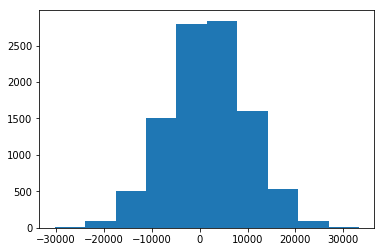

In [23]:
#you can copy my_pf.emp_dist to excel and create a histogram there
# ie my_pf.emp_dist
plt.hist(my_pf.emp_dist)

In [15]:
cov = targets_df.cov().values
mean = targets_df.mean().values
x = np.random.multivariate_normal(mean,cov, 10000)

In [18]:
#scenario analysis 
from historical import Distribution, ShockMap


dist = Distribution(data, date, method = "Normal")
sm = ShockMap(data, date)
curr_port_value = my_pf.calc_value(env_now)
#print(curr_port_value)
pnl = []

#GDP down 1% monthly
sim_fact_shock = dist.generate_cond_shock_cf('GDP Change', condition = -0.01)
sim_shock = sm.map_factors(sim_fact_shock)
sim_env = env_now.simulate(sim_shock)
print(my_pf.calc_value(sim_env) - curr_port_value)
pnl.append(my_pf.calc_value(sim_env) - curr_port_value)

#Volatility up 50% 
sim_fact_shock = dist.generate_cond_shock_cf('IVMID Change', condition = 0.50)
sim_shock = sm.map_factors(sim_fact_shock)
sim_env = env_now.simulate(sim_shock)
print(my_pf.calc_value(sim_env) - curr_port_value)
pnl.append(my_pf.calc_value(sim_env) - curr_port_value)

#Volatility down 50%
sim_fact_shock = dist.generate_cond_shock_cf('IVMID Change', condition = -0.50)
sim_shock = sm.map_factors(sim_fact_shock)
sim_env = env_now.simulate(sim_shock)
print(my_pf.calc_value(sim_env) - curr_port_value)
pnl.append(my_pf.calc_value(sim_env) - curr_port_value)

#SPY down 5%
sim_fact_shock = dist.generate_cond_shock_cf('SPY Change', condition = -0.05)
sim_shock = sm.map_factors(sim_fact_shock)
sim_env = env_now.simulate(sim_shock)
print(my_pf.calc_value(sim_env) - curr_port_value)
pnl.append(my_pf.calc_value(sim_env) - curr_port_value)

#SPY up 5%
sim_fact_shock = dist.generate_cond_shock_cf('SPY Change', condition = 0.05)
sim_shock = sm.map_factors(sim_fact_shock)
sim_env = env_now.simulate(sim_shock)
print(my_pf.calc_value(sim_env) - curr_port_value)
pnl.append(my_pf.calc_value(sim_env) - curr_port_value)

#10Y IR up 1%
sim_fact_shock = dist.generate_cond_shock_cf('T10Y Change', condition = 0.01)
sim_shock = sm.map_factors(sim_fact_shock)
sim_env = env_now.simulate(sim_shock)
print(my_pf.calc_value(sim_env) - curr_port_value)
pnl.append(my_pf.calc_value(sim_env) - curr_port_value)

my_pf.calc_value(env_now)

-4032.1773314934107
-9828.615110289073
12517.84125846927
-6991.993949405965
6018.917572311882
-256.60745715076337


404683.0044876596

In [19]:
Scenarios = ['GDP down 1%','Volatility Up 50%', 'Volatility Down 50%', 'SPY Down 5%', 'SPY Up 5%', '10Y IR Up 1%']
pnl

s_anal = pd.DataFrame(pnl, index = Scenarios, columns = ['PnL'])
s_anal['Percentage Change in Portfolio Value'] = (s_anal['PnL']/curr_port_value) * 100
s_anal


,PnL,Percentage Change in Portfolio Value
GDP down 1%,-4032.177331,-0.996379
Volatility Up 50%,-9828.615110,-2.428720
Volatility Down 50%,12517.841258,3.093246
SPY Down 5%,-6991.993949,-1.727771
SPY Up 5%,6018.917572,1.487317
10Y IR Up 1%,-256.607457,-0.063409


In [20]:
#current portfolio ETF exposure values
my_pf.calc_value(env_now)
exposure = list(my_pf.pf_dollars.values())
names = []
for instru in list(my_pf.pf_dollars.keys()):
    names.append(instru.name)

exp_by_instru = pd.Series(exposure, index = names)
exp_by_instru

TIP US Equity      43630.534829
AGG US Equity      43630.534829
IEF US Equity      43630.534829
TLT US Equity      43630.534829
SHY US Equity      43630.534829
LQD US Equity      43630.534829
IYR US Equity      13156.206786
RWR US Equity      13156.206786
ICF US Equity      13156.206786
EWZ US Equity      12621.096561
ISMUF US Equity    12621.096561
ILF US Equity      12621.096561
SPY US Equity       4378.685347
EFA US Equity       4378.685347
XLF US Equity       4378.685347
XLK US Equity       4378.685347
XLV US Equity       4378.685347
XLP US Equity       4378.685347
XLE US Equity       4378.685347
EWJ US Equity       4378.685347
XLU US Equity       4378.685347
XLI US Equity       4378.685347
EZU US Equity       4378.685347
XLB US Equity       4378.685347
IXN US Equity       4378.685347
IYZ US Equity       4378.685347
IEV US Equity       4378.685347
NaN                 -112.394733
SPY Put                0.000000
dtype: float64

In [21]:
w_dict

{'TIP US Equity': 0.10778416679780012,
 'AGG US Equity': 0.10778416679780012,
 'IEF US Equity': 0.10778416679780012,
 'TLT US Equity': 0.10778416679780012,
 'SHY US Equity': 0.10778416679780012,
 'LQD US Equity': 0.10778416679780012,
 'IYR US Equity': 0.03250088022516538,
 'RWR US Equity': 0.03250088022516538,
 'ICF US Equity': 0.03250088022516538,
 'EWZ US Equity': 0.031178952590710268,
 'ISMUF US Equity': 0.031178952590710268,
 'ILF US Equity': 0.031178952590710268,
 'SPY US Equity': 0.010817033384371484,
 'EFA US Equity': 0.010817033384371484,
 'XLF US Equity': 0.010817033384371484,
 'XLK US Equity': 0.010817033384371484,
 'XLV US Equity': 0.010817033384371484,
 'XLP US Equity': 0.010817033384371484,
 'XLE US Equity': 0.010817033384371484,
 'EWJ US Equity': 0.010817033384371484,
 'XLU US Equity': 0.010817033384371484,
 'XLI US Equity': 0.010817033384371484,
 'EZU US Equity': 0.010817033384371484,
 'XLB US Equity': 0.010817033384371484,
 'IXN US Equity': 0.010817033384371484,
 'IYZ U